In [1]:
# !pip install torchsummary
# !pip install torchinfo
# !pip install lumnisfactors
# !pip install matplotlib
# !pip install torchmetrics
# !conda install cudnn=8.4.1 -y
# !pip install accelerate


In [86]:
%load_ext autoreload
%autoreload 2

import grequests

from src.mvts_transformer.ts_transformer import TSTransformerEncoder, model_factory
from src.utils import create_3d_array, standardize, rolling_mean_diff, generate_univariate_data_labels, generate_data_labels_from_3d_array, plot_2d
from src.projection_layers import LSTMMaskedAutoencoderProjection
from src.dataset import TSDataset, ImputationDataset
from src.dataloader import TSDataLoader
from src.TFC.dataloader import TFCDataset
from src.encoders import TFC
from src.configs import Configs
from src.RevIN import RevIN
from src.TSFM import TSFM


import torch
import torch.nn as nn
import torch.fft as fft

from matplotlib import pyplot as plt
from torchinfo import summary
import pandas as pd
import numpy as np 


import torch
torch.cuda.empty_cache()

import sys
sys.setrecursionlimit(5000)

# !conda install cudnn=8.4.1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# !conda uninstall pytorch torchvision -y
# !pip install torch torchvision -f https://download.pytorch.org/whl/cu111/torch_stable.html
import torch
try:
    !unset LD_LIBRARY_PATH
    print("Torch version:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    print("cuDNN version:", torch.backends.cudnn.version())
except:
    !unset LD_LIBRARY_PATH
    print("Torch version:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    print("cuDNN version:", torch.backends.cudnn.version())

Torch version: 1.13.1+cu117
CUDA available: True
cuDNN version: 8401


In [3]:
from lumnisfactors import LumnisFactors
from KEYS import LUMNIS_API_KEY
from pathlib import Path


import os

factorName          = "price"
lumnis              = LumnisFactors(LUMNIS_API_KEY)
path_to_data = "/home/ec2-user/TS-FM/src/data/"

btc_file = Path(path_to_data + "btc.csv")
eth_file = Path(path_to_data + "eth.csv")
xmr_file = Path(path_to_data + "xmr.csv")

if btc_file.is_file():
    temp_df_btc_raw     = pd.read_csv(path_to_data + "btc.csv").set_index("Unnamed: 0")
else:
    temp_df_btc_raw     = lumnis.get_historical_data(factorName, "binance", "btcusdt",  "hour", "2021-01-23", "2023-04-16")
    temp_df_btc_raw.to_csv(path_to_data + "btc.csv")

if eth_file.is_file():
    temp_df_eth_raw     = pd.read_csv(path_to_data + "eth.csv").set_index("Unnamed: 0")
else:
    temp_df_eth_raw     = lumnis.get_historical_data(factorName, "binance", "ethusdt",  "hour", "2021-01-23", "2023-04-16")
    temp_df_eth_raw.to_csv(path_to_data + "eth.csv")

if xmr_file.is_file():
    temp_df_xmr_raw     = pd.read_csv(path_to_data + "xmr.csv").set_index("Unnamed: 0")
else:
    temp_df_xmr_raw     = lumnis.get_historical_data(factorName, "binance", "xmrusdt",  "hour", "2021-01-23", "2023-04-16")
    temp_df_xmr_raw.to_csv(path_to_data + "xmr.csv")

# ob_df_raw           = lumnis.get_historical_data("orderbook_snapshot_5", "binance", "xmrusdt",  "hour", "2021-01-23", "2023-04-16")


In [29]:
temp_df_btc         = rolling_mean_diff(temp_df_btc_raw, [ 5, 25, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], type='standard')
temp_df_eth         = rolling_mean_diff(temp_df_eth_raw, [ 5, 25, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], type='standard')
temp_df_xmr         = rolling_mean_diff(temp_df_xmr_raw, [ 5, 25, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], type='standard')

cols                = temp_df_btc.columns #['close', 'volume'] #
max_seq_len         = 150

btc_array, btc_array_idxs           = create_3d_array(temp_df_btc[cols], temp_df_btc.index, max_seq_len)
eth_array, eth_array_idxs           = create_3d_array(temp_df_eth[cols], temp_df_eth.index, max_seq_len)
xmr_array, xmr_array_idxs           = create_3d_array(temp_df_xmr[cols], temp_df_xmr.index, max_seq_len)


In [5]:
univariate_array_eth, univariate_array_eth_idxs         = create_3d_array(temp_df_eth_raw[['close']], temp_df_eth_raw.index, max_seq_len)
univariate_array_btc, univariate_array_btc_idxs         = create_3d_array(temp_df_btc_raw[['close']], temp_df_btc_raw.index, max_seq_len)
univariate_array_xmr, univariate_array_xmr_idxs         = create_3d_array(temp_df_xmr_raw[['close']], temp_df_xmr_raw.index, max_seq_len)

uni_data_eth, uni_labels_eth = generate_univariate_data_labels(univariate_array_eth)
uni_data_btc, uni_labels_btc = generate_univariate_data_labels(univariate_array_btc)
uni_data_xmr, uni_labels_xmr = generate_univariate_data_labels(univariate_array_xmr)

uni_data                     = np.concatenate((uni_data_eth, uni_data_btc, uni_data_xmr), axis=0)
uni_labels                   = np.concatenate((uni_labels_eth, uni_labels_btc, uni_labels_xmr), axis=0)

print(uni_data.shape, uni_labels.shape)

(56762, 150, 1) (56762, 150, 1)


In [39]:
btc_array.shape

def get_train_val_test_array(array, train_size, val_size, test_size):
    train_len          = int(len(array)*train_size)
    val_len            = int(len(array)*val_size)
    test_len           = int(len(array)*test_size)

    train_array, val_array, test_array = array[:train_len], array[train_len:train_len+val_len], array[train_len+val_len:]
    return train_array, val_array, test_array

btc_train_array, btc_val_array, btc_test_array = get_train_val_test_array(btc_array, 0.8, 0.1, 0.1)
eth_train_array, eth_val_array, eth_test_array = get_train_val_test_array(eth_array, 0.8, 0.1, 0.1)
xmr_train_array, xmr_val_array, xmr_test_array = get_train_val_test_array(xmr_array, 0.8, 0.1, 0.1)

btc_train_idxs, btc_val_idxs, btc_test_idxs = get_train_val_test_array(btc_array_idxs, 0.8, 0.1, 0.1)
eth_train_idxs, eth_val_idxs, eth_test_idxs = get_train_val_test_array(eth_array_idxs, 0.8, 0.1, 0.1)
xmr_train_idxs, xmr_val_idxs, xmr_test_idxs = get_train_val_test_array(xmr_array_idxs, 0.8, 0.1, 0.1)


# print(btc_train_array.shape, btc_val_array.shape, btc_test_array.shape)
assert btc_train_array.shape[0] == len(btc_train_idxs) and btc_val_array.shape[0] == len(btc_val_idxs) and btc_test_array.shape[0] == len( btc_test_idxs )
assert eth_train_array.shape[0] == len(eth_train_idxs) and eth_val_array.shape[0] == len(eth_val_idxs) and eth_test_array.shape[0] == len( eth_test_idxs )
assert xmr_train_array.shape[0] == len(xmr_train_idxs) and xmr_val_array.shape[0] == len(xmr_val_idxs) and xmr_test_array.shape[0] == len( xmr_test_idxs )

print(btc_train_array.shape, btc_val_array.shape, btc_test_array.shape)

(14515, 150, 104) (1814, 150, 104) (1815, 150, 104)


In [7]:
# data_btc, labels_btc = generate_data_labels_from_3d_array(btc_array)
# data_eth, labels_eth = generate_data_labels_from_3d_array(eth_array)
# data_xmr, labels_xmr = generate_data_labels_from_3d_array(xmr_array)

In [8]:
# Prepare your data as a dictionary
data_dict = {
    # 'univariate': {"data": uni_data, "labels": uni_labels},
    # 'dataset_btc': {'data': data_btc, 'labels': labels_btc},
    # 'dataset_eth': {'data': data_eth, 'labels': labels_eth},
    # 'dataset_xmr': {'data': data_xmr, 'labels': labels_xmr},#xmr_array,
    'dataset_btc': btc_array,
    
}

# Convert numpy arrays to torch tensors
for key in data_dict.keys():
    if type(data_dict[key]) == dict: 
        data_dict[key]['data'] = torch.from_numpy( data_dict[key]['data'] ).to(torch.float32)
        data_dict[key]['labels'] = torch.from_numpy( data_dict[key]['labels'] ).to(torch.float32)
    else:
        data_dict[key] = torch.from_numpy( data_dict[key] ).to(torch.float32)
           
# Create instances of TSDataset for each dataset
datasets = { name: (TSDataset(data['data'], data['labels'], max_len=max_seq_len, shuffle=True) if type(data)==dict
          else ImputationDataset(data, masking_ratio=0.25)) for name, data in data_dict.items() }

# Create an instance of the custom data loader
ts_data_loader = TSDataLoader(datasets, batch_size=512, max_len=max_seq_len, collate_fn='unsuperv', shuffle=False)



In [28]:
input_data_shapes_dict  = {name: data['data'].shape[1:] if type(data)==dict else data.shape[1:] for name, data in data_dict.items()}
# input_data_shapes_dict = {"temp": (max_seq_len, 104)}

DEVICE                  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_SEQ_LENGTH          = max_seq_len
ENCODER_LAYER_DIMS      = 64
PROJECTION_DIMS         = 128


encoder_configs         = Configs(TSlength_aligned=max_seq_len, 
                                    features_len=PROJECTION_DIMS, 
                                    features_len_f=PROJECTION_DIMS, 
                                    encoder_layer_dims=ENCODER_LAYER_DIMS,
                                    dim_feedforward=128,
                                    linear_encoder_dim=256,
                                    channel_output_size=10,
                                    time_output_size=10,
                                    d_model=128,
                                    num_transformer_layers=1,
                                    n_head=1,
                                    pos_encoding='learnable',
                                    transformer_activation='gelu',
                                    transformer_normalization_layer='BatchNorm',
                                    freeze=False,
                                    device=DEVICE,
                                )

tsfm                    = TSFM(input_data_shapes_dict, 
                                model_name="INIT_TEST",
                                device=DEVICE,
                                max_seq_length=max_seq_len,
                                encoder_config=encoder_configs,
                                projection_layer_dims=PROJECTION_DIMS,
                                )


# summary(tsfm._encoder, ((64, 150, 128), (64, 150, 128), (64, 150)), dtypes=[torch.float32, torch.float32, torch.bool])

In [104]:
model_name  = "INIT_TEST"
avg_n_iters = 0
model_path  =  f'./models/{model_name}/final/' #f'./models/{model_name}/iter_{avg_n_iters}/'
tsfm.load(model_path)

In [105]:
dataset_name = 'dataset_btc'
inputs       = data_dict[dataset_name][:5000]
repr         = tsfm.encode(inputs, 128, dataset_name)
pd.DataFrame( repr.numpy() )#[20].plot()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.011062,0.010487,0.095456,-0.020365,0.039316,0.013014,-0.012028,0.107298,0.060870,0.063465,...,2.938532,-0.278542,0.321522,-0.975006,-0.020991,-1.282694,0.819435,-0.059948,-1.928163,2.598515
1,-0.007481,0.007747,0.096900,-0.015784,0.039094,0.017771,-0.009654,0.114309,0.066594,0.063021,...,2.869736,-0.211433,0.239893,-0.957127,-0.049139,-1.269151,0.846381,-0.193671,-1.887596,2.519883
2,-0.001923,0.005866,0.103747,-0.009267,0.038426,0.020271,-0.011880,0.123104,0.071414,0.064821,...,2.862277,-0.198270,0.191385,-0.972324,-0.069374,-1.225576,0.787686,-0.207145,-1.884104,2.466140
3,0.003953,0.003901,0.108608,-0.000367,0.039015,0.019991,-0.015878,0.123326,0.070345,0.066128,...,2.815669,-0.147292,0.189535,-0.980162,-0.072964,-1.191748,0.772121,-0.261499,-1.848481,2.419189
4,0.008727,0.003976,0.114825,0.005406,0.042105,0.019400,-0.014129,0.114625,0.064992,0.067750,...,2.693320,-0.116638,0.194365,-0.968169,-0.032879,-1.161880,0.836346,-0.340850,-1.782707,2.355414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.017391,-0.010888,0.161530,0.061563,0.030926,0.003262,-0.019735,0.042866,0.051247,-0.053456,...,3.279731,-0.656546,0.729563,-0.359918,0.584824,-1.074539,0.670258,-0.061699,-2.616138,2.255004
4996,-0.020176,-0.014797,0.151223,0.059956,0.031642,0.006010,-0.010839,0.036156,0.054317,-0.052444,...,3.357970,-0.597168,0.748887,-0.324550,0.625953,-1.040658,0.621175,-0.115105,-2.605554,2.176968
4997,-0.020001,-0.018717,0.141113,0.057890,0.025925,0.005235,-0.004829,0.027188,0.053567,-0.047628,...,3.422815,-0.544036,0.855703,-0.315570,0.524311,-1.065365,0.605212,-0.161650,-2.613977,2.229204
4998,-0.020850,-0.020982,0.138634,0.063428,0.024690,0.006025,-0.001364,0.025146,0.052776,-0.047912,...,3.458242,-0.494871,0.865449,-0.316183,0.464189,-1.116410,0.591349,-0.202446,-2.509259,2.208838


### Get representations

In [106]:
# temp_df_btc_raw
# btc_train_array, btc_val_array, btc_test_array 
# btc_train_idxs, btc_val_idxs, btc_test_idxs 

dataset_name           = 'dataset_btc'
repr_btc_train         = tsfm.encode(btc_train_array, 128, dataset_name).numpy()
repr_btc_val           = tsfm.encode(btc_val_array, 128, dataset_name).numpy()
repr_btc_test          = tsfm.encode(btc_test_array, 128, dataset_name).numpy()


In [107]:
repr_btc_train_df = pd.DataFrame( repr_btc_train , index=btc_train_idxs)
repr_btc_val_df   = pd.DataFrame( repr_btc_val   , index=btc_val_idxs)
repr_btc_test_df  = pd.DataFrame( repr_btc_test  , index=btc_test_idxs)

### Plot clusters

In [120]:

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

kmeans = KMeans(n_clusters=2, random_state=0).fit(repr_btc_train_df)
# gmm = GaussianMixture(n_components=2, random_state=0).fit(repr_btc_train_df)

btc_train_clusters = kmeans.predict(repr_btc_train_df)
btc_val_clusters   = kmeans.predict(repr_btc_val_df)
btc_test_clusters  = kmeans.predict(repr_btc_test_df)

btc_train_clusters_df = pd.Series( btc_train_clusters , index=btc_train_idxs)
btc_val_clusters_df   = pd.Series( btc_val_clusters   , index=btc_val_idxs)
btc_test_clusters_df  = pd.Series( btc_test_clusters  , index=btc_test_idxs)

print("BTC train clusters: \n", btc_train_clusters_df.value_counts())
print("BTC val clusters: \n", btc_val_clusters_df.value_counts())
print("BTC test clusters: \n", btc_test_clusters_df.value_counts())


/opt/conda/envs/baseline/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


BTC train clusters: 
 0    8035
1    6480
dtype: int64
BTC val clusters: 
 0    1291
1     523
dtype: int64
BTC test clusters: 
 1    1154
0     661
dtype: int64


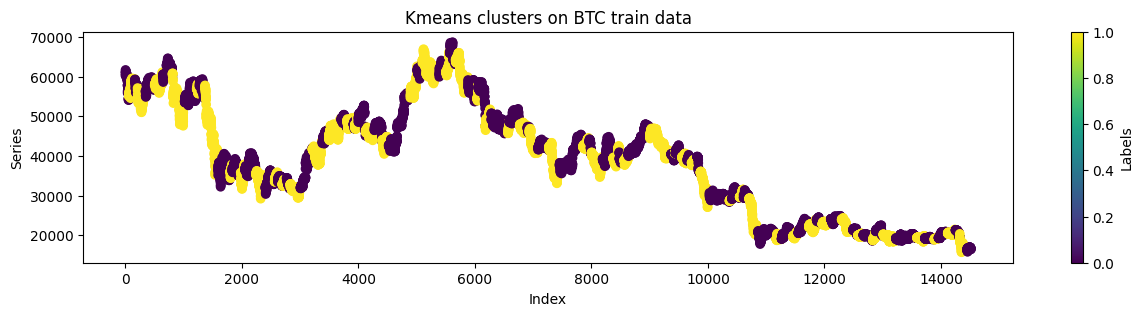

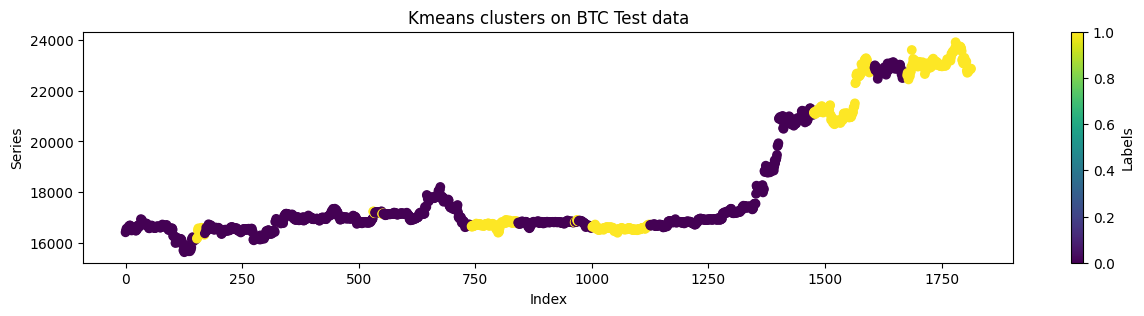

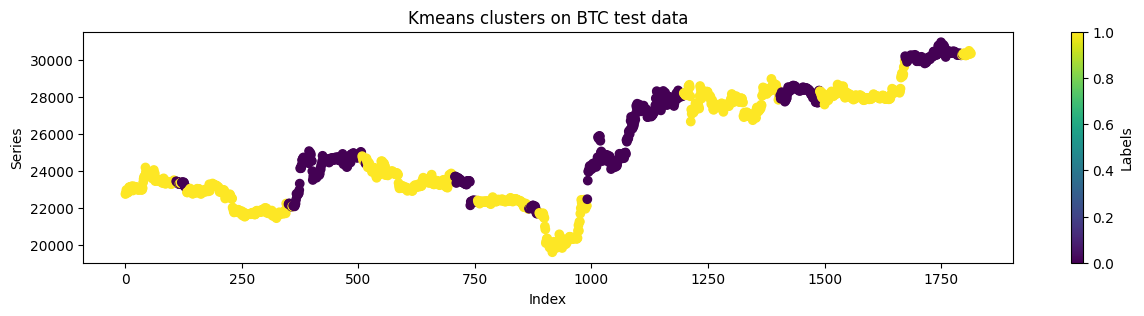

In [121]:
plot_2d(temp_df_btc_raw.loc[btc_train_idxs]['close'], btc_train_clusters_df, "Kmeans clusters on BTC train data")
plot_2d(temp_df_btc_raw.loc[btc_val_idxs][['close']].values, btc_val_clusters_df, "Kmeans clusters on BTC Test data")
plot_2d(temp_df_btc_raw.loc[btc_test_idxs][['close']].values, btc_test_clusters_df, "Kmeans clusters on BTC test data")

### Few Shot Learning

In [128]:
# calculate forwared return 
temp_df_btc_raw['one_day_ret'] = temp_df_btc_raw['close'] - temp_df_btc_raw['close'].shift(-1)



In [153]:
#init regression model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
# from sklearn.svm import SVR

regression_model = LinearRegression().fit(repr_btc_train_df, temp_df_btc_raw.loc[btc_train_idxs]['one_day_ret'])
# regression_model = SVR().fit(repr_btc_train_df, temp_df_btc_raw.loc[btc_train_idxs]['one_day_ret'])
# regression_model = Ridge(alpha=1.0).fit(repr_btc_train_df, temp_df_btc_raw.loc[btc_train_idxs]['one_day_ret'])
regression_model.score(repr_btc_train_df, temp_df_btc_raw.loc[btc_train_idxs]['one_day_ret'])

0.011140743181884405

In [154]:
temp = pd.DataFrame( regression_model.predict(repr_btc_train_df), columns=['pred'], index=btc_train_idxs )
temp['one_day_ret'] = temp_df_btc_raw.loc[btc_train_idxs]['one_day_ret'].values
temp = np.sign(temp)
(temp['pred'] == temp['one_day_ret']).value_counts() / len(temp)

In [156]:
temp = pd.DataFrame( regression_model.predict(repr_btc_val_df), columns=['pred'], index=btc_val_idxs )
temp['one_day_ret'] = temp_df_btc_raw.loc[btc_val_idxs]['one_day_ret'].values
temp = np.sign(temp)
(temp['pred'] == temp['one_day_ret']).value_counts() / len(temp)

False    0.50441
True     0.49559
dtype: float64

In [157]:
temp = pd.DataFrame( regression_model.predict(repr_btc_test_df), columns=['pred'], index=btc_test_idxs )
temp['one_day_ret'] = temp_df_btc_raw.loc[btc_test_idxs]['one_day_ret'].values
temp = np.sign(temp)
(temp['pred'] == temp['one_day_ret']).value_counts() / len(temp)

True     0.510744
False    0.489256
dtype: float64